# Abalone dataset

Here I'd like to analyse Abalone dataset (https://archive.ics.uci.edu/ml/datasets/Abalone). 

**Data comes from an original (non-machine-learning) study:**
Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford (1994)
"The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait",
Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288)

**Original Owners of Database:**
Marine Resources Division
Marine Research Laboratories - Taroona
Department of Primary Industry and Fisheries, Tasmania
GPO Box 619F, Hobart, Tasmania 7001, Australia
(contact: Warwick Nash +61 02 277277, wnash '@' dpi.tas.gov.au)

**Features:**<br>
sex - M, F, and I (infant)<br>
length (mm) - Longest shell measurement<br>
diameter (mm) - perpendicular to length<br>
height (mm) - with meat in shell<br>
whole_weight (grams) - whole abalone<br>
shucked_weight (grams) - weight of meat<br>
viscera_weight (grams) - gut weight (after bleeding)<br>
shell_weight (grams) - after being dried<br>
rings - +1.5 gives the age in years (***target feature***)<br>

I decided to treat dataset as a 3-category classification problem (similat to paper David Clark, Zoltan Schreter, Anthony Adams "A Quantitative Comparison of Dystal and Backpropagation", submitted to the Australian Conference on Neural Networks (ACNN'96)).<br>
Ring amounts were grouped in 3 classes: 0 -- 1-8 rings, 1 -- 9-10 rings, 2 -- >=11 rings.

In [1]:
# make warnings hidden
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
# make pandas to show all columns (default - 20)
pd.set_option('display.max_columns', 100)

# load libraries for visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
# set style of all figures to darkgrid
sns.set_style('whitegrid')

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR, LinearSVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
def print_statistics(y_test, y_pred):
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')

In [4]:
df = pd.read_csv('./abalone.data', names=['sex', 'length', 'diameter', 'height',
                                                       'whole_weight', 'shucked_weight', 'viscera_weight',
                                                       'shell_weight', 'rings'])

Numerical attributes of dataframe were divided by 200. Let's restore initial values.

In [5]:
df[df.columns[df.dtypes=='float']] = df[df.columns[df.dtypes=='float']] * 200

In [6]:
df.shape

(4177, 9)

In [7]:
df.dtypes

sex                object
length            float64
diameter          float64
height            float64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings               int64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [9]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,91.0,73.0,19.0,102.8,44.9,20.2,30.0,15
1,M,70.0,53.0,18.0,45.1,19.9,9.7,14.0,7
2,F,106.0,84.0,27.0,135.4,51.3,28.3,42.0,9
3,M,88.0,73.0,25.0,103.2,43.1,22.8,31.0,10
4,I,66.0,51.0,16.0,41.0,17.9,7.9,11.0,7


Let's look on statistical characteristics of the data.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,4177.0,104.798420,24.018583,15.0,90.0,109.0,123.0,163.0
diameter,4177.0,81.576251,19.847973,11.0,70.0,85.0,96.0,130.0
height,4177.0,27.903280,8.365411,0.0,23.0,28.0,33.0,226.0
whole_weight,4177.0,165.748432,98.077804,0.4,88.3,159.9,230.6,565.1
shucked_weight,4177.0,71.873498,44.392590,0.2,37.2,67.2,100.4,297.6
viscera_weight,4177.0,36.118722,21.922850,0.1,18.7,34.2,50.6,152.0
shell_weight,4177.0,47.766172,27.840534,0.3,26.0,46.8,65.8,201.0
rings,4177.0,9.933684,3.224169,1.0,8.0,9.0,11.0,29.0


In [11]:
df.describe(include='object').T

,count,unique,top,freq
sex,4177,3,M,1528


There are no NaN values in dataset. But some features have outliers, which can cause incorrect results during futher modeling.

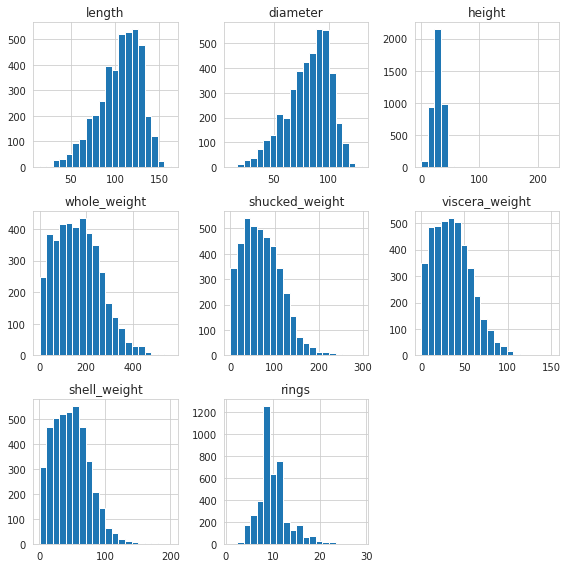

In [12]:
df.hist(figsize=(8, 8), bins=20)
plt.tight_layout()

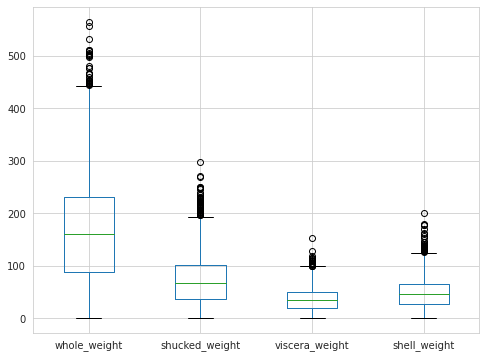

In [13]:
plt.figure(figsize=(8, 6))
df.iloc[:, [4, 5, 6, 7]].boxplot();

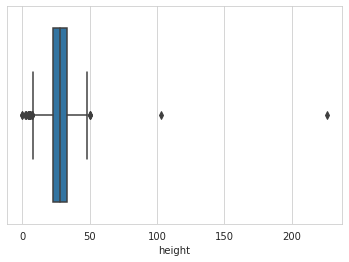

In [14]:
sns.boxplot(x='height', data=df);

Length and diameter features have almost normal distibution. Weight features are skewed to the left. We can try to transform these features to get more normal-like distribution. Quite convenient way to assess skewness of data is pandas .skew() method (Fisher-Pearson standardized moment).

In [15]:
df.skew().sort_values(ascending=False)

height            3.128817
rings             1.114102
shucked_weight    0.719098
shell_weight      0.620927
viscera_weight    0.591852
whole_weight      0.530959
diameter         -0.609198
length           -0.639873
dtype: float64

 According to the figures, the skewest feature is height. According to stat table it has quite big amount of outliers, that can cause some discrepancies in futher modeling.

In [16]:
df.drop(index=df[(df['height'] > 100) | (df['height']==0)].index, inplace=True)

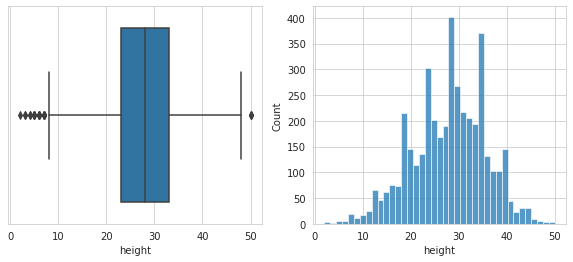

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(x='height', data=df, ax=axs[0])
sns.histplot(x='height', data=df, ax=axs[1]);

As you can see height feature has almost normal distribution.

Let's explore some quantitave dependencies of features from dataframe.

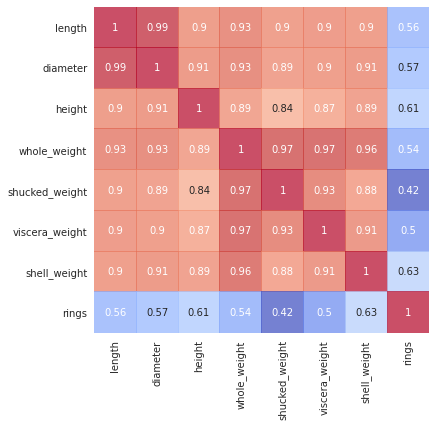

In [18]:
corr_matrix = df.corr()

plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, cmap=plt.cm.coolwarm, annot=True, alpha=0.7, cbar=False);

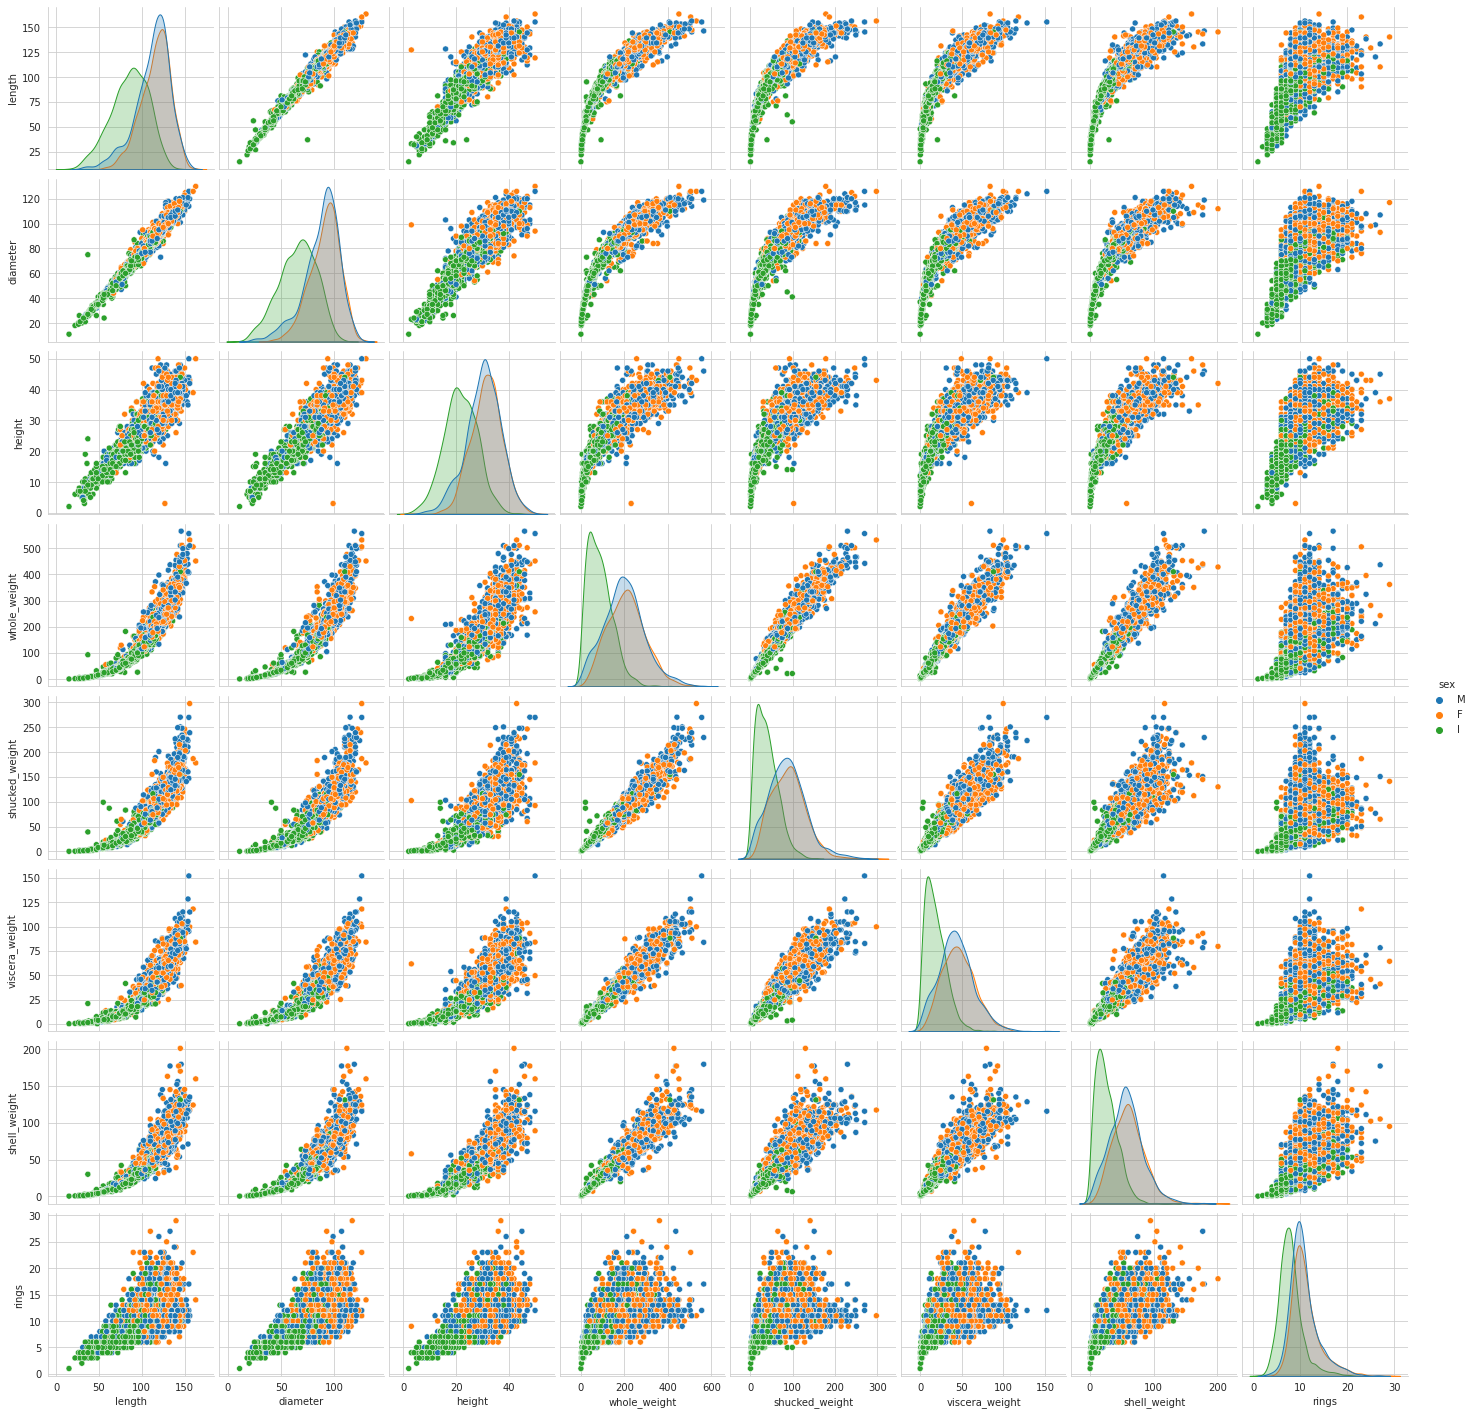

In [19]:
sns.pairplot(df, hue='sex');

We see from the plots above that all features have strong positive correlation. And, to be honest, it is obvious (the heaviest abalones are larger, and vice versa). Also we see, that all features have almost identical distribution in different sex groups: male and female creatures have similar distributions, modes of which are shifted to the right from the distribution of infant abalones.

Now we need to take a closer look at the possible connection of features to the target (amount of rings).

In [20]:
corr_matrix['rings'].sort_values(ascending=False)

rings             1.000000
shell_weight      0.628169
height            0.610107
diameter          0.574551
length            0.556572
whole_weight      0.540621
viscera_weight    0.503977
shucked_weight    0.421156
Name: rings, dtype: float64

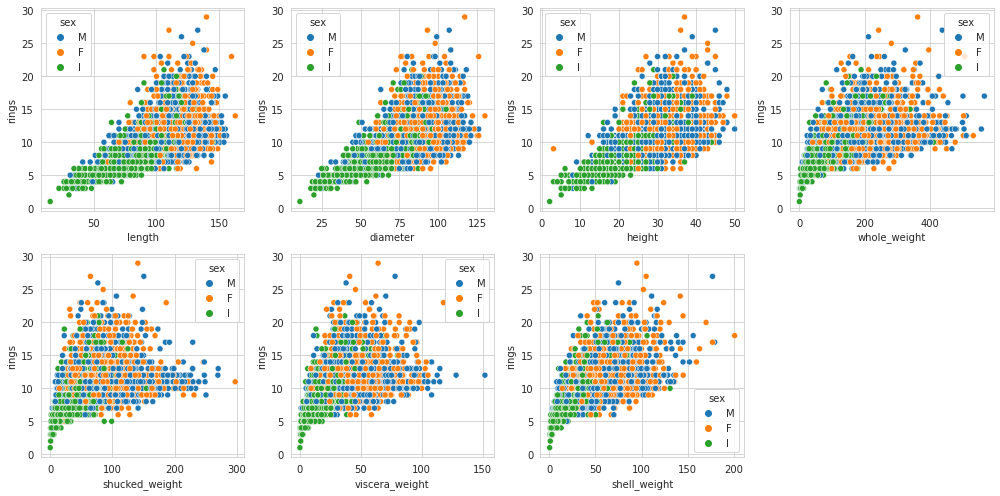

In [21]:
num_features = df.select_dtypes(exclude='object').drop('rings', axis=1).columns

plt.figure(figsize=(14, 7))
for i, feature in enumerate(num_features):
    plt.subplot(2, 4, i+1)
    sns.scatterplot(x=feature, y='rings', data=df, hue='sex')
    plt.tight_layout();

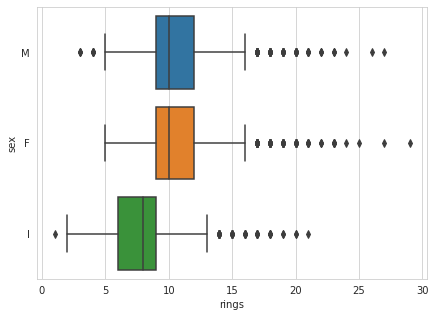

In [22]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='rings', y='sex', data=df);

<Figure size 504x432 with 0 Axes>

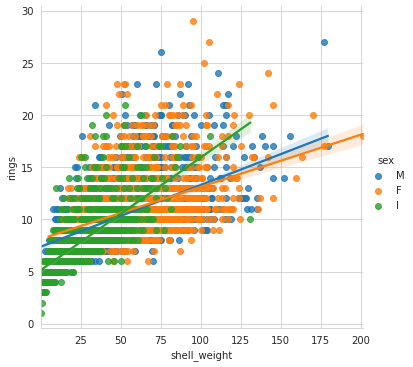

In [23]:
plt.figure(figsize=(7, 6))
sns.lmplot(x='shell_weight', y='rings', data=df, hue='sex');

<Figure size 504x432 with 0 Axes>

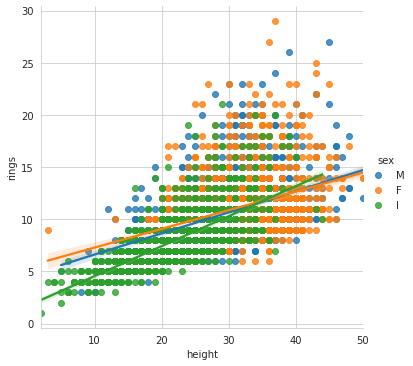

In [24]:
plt.figure(figsize=(7, 6))
sns.lmplot(x='height', y='rings', data=df, hue='sex');

From the analysis of above figures we see, that all numerical features have positive linear correlation with amount of rings. Height and shell weight have the largest values. Also it can be noticed from the boxplots, that infant abalones have less has less rings than creatures from male and female groups.

In [25]:
X = df.drop('rings', axis=1)
y = df['rings'].values

In [26]:
num_features = X.select_dtypes(exclude='object').columns.tolist()
cat_features = ['sex']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [28]:
transformer = ColumnTransformer(transformers=[('scaler', StandardScaler(), num_features),
                                              ('encoder', OneHotEncoder(), cat_features)],
                               remainder='passthrough')

In [29]:
X_train_tr = transformer.fit_transform(X_train)
X_test_tr = transformer.transform(X_test)

## Modeling

### Out-of-box

In [30]:
lasso = Lasso()
-cross_val_score(lasso, X_train_tr, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

2.6628774581582513

In [31]:
ridge = Ridge()
-cross_val_score(ridge, X_train_tr, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

2.173230165618302

In [32]:
elastic = ElasticNet()
-cross_val_score(elastic, X_train_tr, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

2.583370762672042

In [33]:
lin_svr = LinearSVR()
-cross_val_score(lin_svr, X_train_tr, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

2.2296458873527745

In [34]:
svr = SVR(kernel='rbf')
-cross_val_score(svr, X_train_tr, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

2.177676711047125

In [35]:
tree = DecisionTreeRegressor()
-cross_val_score(tree, X_train_tr, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

2.9445358421420313

In [36]:
forest = RandomForestRegressor()
-cross_val_score(forest, X_train_tr, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

2.1802257047576057

In [37]:
knn = KNeighborsRegressor()
-cross_val_score(knn, X_train_tr, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

2.3294462365777537

### Tuning

#### RandomForest

In [38]:
%%time
forest = RandomForestRegressor()
param_grid = {'n_estimators': [100, 200],
              'max_depth': [7, 9, 11],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [4, 5, 6]}
grid_forest = GridSearchCV(forest, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_forest.fit(X_train_tr, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
CPU times: user 3.7 s, sys: 43.5 ms, total: 3.74 s
Wall time: 1min 32s


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 9, 11], 'min_samples_leaf': [4, 5, 6],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [39]:
grid_forest.best_params_

{'max_depth': 9,
 'min_samples_leaf': 6,
 'min_samples_split': 4,
 'n_estimators': 200}

In [40]:
-grid_forest.best_score_

2.1450010801157897

In [41]:
forest_tuned = grid_forest.best_estimator_

In [42]:
print_statistics(y_test, forest_tuned.predict(X_test_tr))

MAE: 1.5079938350712396
MSE: 4.823695641147692
RMSE: 2.196291337948518


#### SVR

In [43]:
svr = SVR()
param_grid = [{'kernel': ['linear'], 'C':[0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['poly'], 'degree': [2, 3], 'coef0': [0.1, 1, 10]},
              {'kernel': ['rbf'], 'gamma': [0.01, 0.1, 1, 10]}]
grid_svr = GridSearchCV(svr, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_svr.fit(X_train_tr, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['linear']},
                         {'coef0': [0.1, 1, 10], 'degree': [2, 3],
                          'kernel': ['poly']},
                         {'gamma': [0.01, 0.1, 1, 10], 'kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error', verbose=1)

In [44]:
grid_svr.best_score_

-2.1263373570361854

In [45]:
grid_svr.best_params_

{'coef0': 10, 'degree': 2, 'kernel': 'poly'}

In [46]:
svr_tuned = grid_svr.best_estimator_

In [47]:
print_statistics(y_test, svr_tuned.predict(X_test_tr))

MAE: 1.4960811492580302
MSE: 4.998308595482962
RMSE: 2.235689735961357


#### Ridge

In [48]:
ridge = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid_ridge = GridSearchCV(ridge, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_ridge.fit(X_train_tr, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg',
                                    'sag', 'saga']},
             scoring='neg_root_mean_squared_error', verbose=1)

In [49]:
grid_ridge.best_params_

{'alpha': 0.001, 'solver': 'lsqr'}

In [50]:
grid_ridge.best_score_

-2.172755347264834

In [51]:
ridge_tuned = grid_ridge.best_estimator_

In [52]:
print_statistics(y_test, ridge_tuned.predict(X_test_tr))

MAE: 1.5859868896706817
MSE: 4.990627935535684
RMSE: 2.2339713372233954


### Ensembles

#### Voting

In [53]:
voting = VotingRegressor(estimators=[('forest_tuned', forest),
                                     ('svr_tuned', svr),
                                     ('ridge_tuned', ridge)])
voting.fit(X_train_tr, y_train)

VotingRegressor(estimators=[('forest_tuned', RandomForestRegressor()),
                            ('svr_tuned', SVR()), ('ridge_tuned', Ridge())])

In [54]:
print_statistics(y_test, voting.predict(X_test_tr))

MAE: 1.4889542785282741
MSE: 4.668630607970968
RMSE: 2.1607014157377153
